# Семинар 2

План семинара:
1. T test - примеры применения
    - односторонний и двусторонний
    - примеры на разных распределениях
2. Сплитовалка
    - подходы к разбиению пользователей на группы для AB теста
    - как валидировать сплитовалку

# 1. T-Test

In [ ]:
from chart_studio import plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import warnings

warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, t

import numpy as np
import pandas as pd
from scipy import stats

## Одновыборочный

Одновыборочный T test проверяем гипотезу о среднем в одной выборке

In [4]:
data1 = np.random.normal(0, 1, size=10_000)
data2 = np.random.normal(2, 1, size=10_000)

In [ ]:
x = np.linspace(-4, 4, 160)
y1 = stats.norm.pdf(x)
y2 = stats.norm.pdf(x, loc=2)

trace1 = go.Scatter(x=x, y=y1, mode="lines+markers", name="Mean of 0")
trace2 = go.Scatter(x=x, y=y2, mode="lines+markers", name="Mean of 2")

fig = go.Figure()

fig.add_trace(trace1)
fig.add_trace(trace2)

fig.show()

На графике видно смещение средних, но визуальная разница — это не доказательство. Дальше закрепим вывод статистикой.


In [6]:
from plotly.figure_factory import create_table

true_mu = 0

onesample_results = stats.ttest_1samp(data1, true_mu)

matrix_onesample = [
    ["", "Test Statistic", "p-value"],
    ["Sample Data", onesample_results[0], onesample_results[1]],
]

onesample_table = create_table(matrix_onesample, index=True)
onesample_table

Интерпретация: если p‑value < 0.05, отвергаем H0. Если p‑value ≥ 0.05 — статистически значимого отличия не нашли.


## Двувыборочный

Two‑sample t‑test сравнивает две независимые выборки (контроль/тест).

Формулируем гипотезы:
- **H0** — средние равны
- **H1** — средние различаются

Используем двустороннюю проверку, если не знаем направление эффекта.

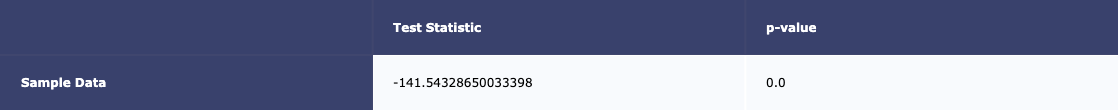

In [ ]:
twosample_results = stats.ttest_ind(data1, data2)

matrix_twosample = [
    ["", "Test Statistic", "p-value"],
    ["Sample Data", twosample_results[0], twosample_results[1]],
]

twosample_table = create_table(matrix_twosample, index=True)
twosample_table

Тот же принцип интерпретации p‑value: маленькое p — против H0.


## T-test для НЕнормального распределения

Существует стереотип, что T test можно применять только на нормальном распределении. На самом деле на практике нормальное распределение встречается крайне редко. Чтобы развеять сомнения, просто просимулируем эксперименты, где мы будем много раз применять T test на распределениях, отличных от нормального. Смотрим частоту ложных срабатываний (ошибка I рода). 


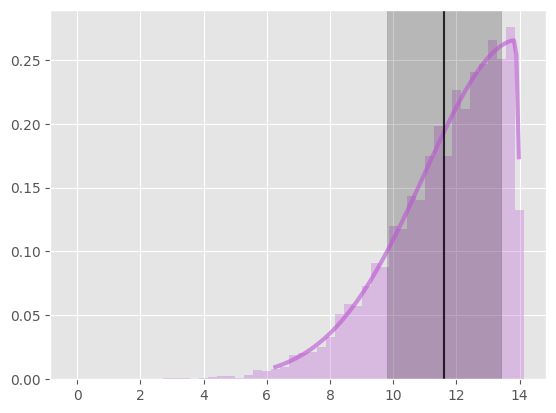

In [37]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats


alpha = 0.05
a = -50
loc = 14
scale = 3
x1 = np.linspace(
    stats.skewnorm.ppf(0.01, a, loc=loc, scale=scale),
    stats.skewnorm.ppf(0.99, a, loc=loc, scale=scale),
    100,
)
skewed = stats.skewnorm.rvs(a, size=10000, loc=loc, scale=scale)
fig, ax = plt.subplots(1, 1)
ax.plot(
    x1,
    stats.skewnorm.pdf(x1, a, loc=loc, scale=scale),
    "r-",
    lw=3,
    alpha=0.6,
    color="mediumorchid",
)
ax.hist(
    skewed,
    density=True,
    histtype="stepfilled",
    bins=50,
    alpha=0.3,
    color="mediumorchid",
)
ax.axvline(np.mean(skewed), ymax=1, color="black", alpha=0.8)
rect = matplotlib.patches.Rectangle(
    (np.mean(skewed) - np.std(skewed), 0),
    2 * np.std(skewed),
    0.3,
    color="black",
    alpha=0.2,
)
ax.add_patch(rect)

In [40]:
samp_size = 10

results = []
for i in tqdm(range(10000)):
    # генерируем одинаковые выборки - они не должны отличаться
    sample1 = np.random.choice(skewed, samp_size)
    sample2 = np.random.choice(skewed, samp_size)
    _, pval = stats.ttest_ind(sample1, sample2)
    results.append(pval < alpha)

fpr = sum(results) / len(results)
print(f"FPR: {fpr:.3f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

FPR: 0.051


Полученное число — оценка доли ложных срабатываний при истинной H0. Ожидаемо около 0.05.


### Экспоненциальное распределение

Экспоненциальное распределение — сильная асимметрия и длинный хвост. Это стресс‑тест для t‑test.


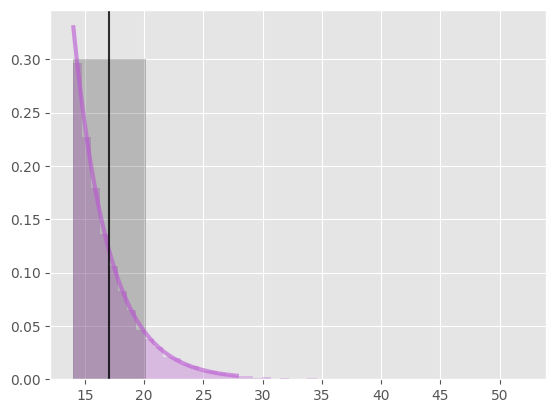

In [41]:
x1 = np.linspace(
    stats.expon.ppf(0.01, loc=loc, scale=scale),
    stats.expon.ppf(0.99, loc=loc, scale=scale),
    100,
)
exponential = stats.expon.rvs(size=10000, loc=loc, scale=scale)
fig, ax = plt.subplots(1, 1)
ax.plot(
    x1,
    stats.expon.pdf(x1, loc=loc, scale=scale),
    "r-",
    lw=3,
    alpha=0.6,
    color="mediumorchid",
)
ax.hist(
    exponential,
    density=True,
    histtype="stepfilled",
    bins=50,
    alpha=0.3,
    color="mediumorchid",
)
ax.axvline(np.mean(exponential), ymax=1, color="black", alpha=0.8)
rect = matplotlib.patches.Rectangle(
    (np.mean(exponential) - np.std(exponential), 0),
    2 * np.std(exponential),
    0.3,
    color="black",
    alpha=0.2,
)
ax.add_patch(rect)

plt.show()

In [42]:
samp_size = 10

results = []
for i in range(10000):
    sample1 = np.random.choice(exponential, samp_size)
    sample2 = np.random.choice(exponential, samp_size)
    _, pval = stats.ttest_ind(sample1, sample2)
    results.append(pval < alpha)

fpr = sum(results) / len(results)
print(f"FPR: {fpr:.3f}")

FPR: 0.041


Снова оцениваем частоту ложноположительных результатов.


### Нормальное

Для нормального распределения t‑test — корректный инструмент, ожидаем близко к номинальному уровню 0.05.


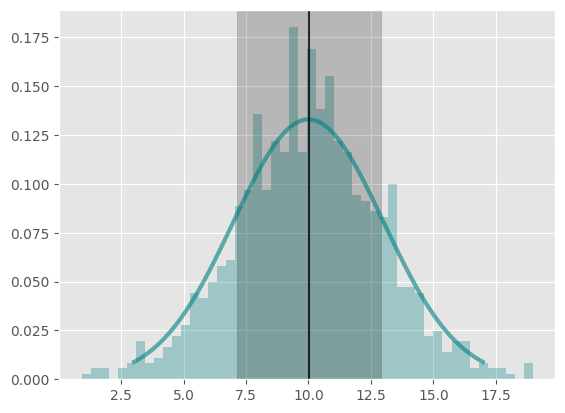

In [43]:
loc = 10
scale = 3
x2 = np.linspace(
    stats.norm.ppf(0.01, loc=loc, scale=scale),
    stats.norm.ppf(0.99, loc=loc, scale=scale),
    100,
)
normal = stats.norm.rvs(size=1000, loc=loc, scale=scale)
fig, ax = plt.subplots(1, 1)
ax.plot(
    x2, stats.norm.pdf(x2, loc=loc, scale=scale), "r-", lw=3, alpha=0.6, color="teal"
)
ax.hist(normal, density=True, histtype="stepfilled", bins=50, alpha=0.3, color="teal")
ax.axvline(np.mean(normal), ymax=1, color="black", alpha=0.8)
rect = matplotlib.patches.Rectangle(
    (np.mean(normal) - np.std(normal), 0),
    2 * np.std(normal),
    0.3,
    color="black",
    alpha=0.2,
)
ax.add_patch(rect)
plt.show()

In [44]:
samp_size = 10

results = []
for i in range(10000):
    sample1 = np.random.choice(normal, samp_size)
    sample2 = np.random.choice(normal, samp_size)
    _, pval = stats.ttest_ind(sample1, sample2)
    results.append(pval < 0.05)
fpr = sum(results) / len(results)

print(f"FPR: {fpr:.3f}")

FPR: 0.050


Если здесь около 0.05 — тест ведет себя как надо.


### Mann Whitney


Mann‑Whitney — непараметрический тест: проверяет гипотезу о **сдвиге распределения**. С ним нужно быть очень аккуратным на практике – легко совершить ошибку.

Просимулируем именно такую картинку - распределения одинаковы по форме и дисперсии, но одно из них "сдвинуто вправо"

In [45]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, t

In [46]:
data1 = 5 * np.random.randn(1000) + 50  # среднее 50, дисперсия 25
data2 = 5 * np.random.randn(1000) + 51  # среднее 51, дисперсия 25

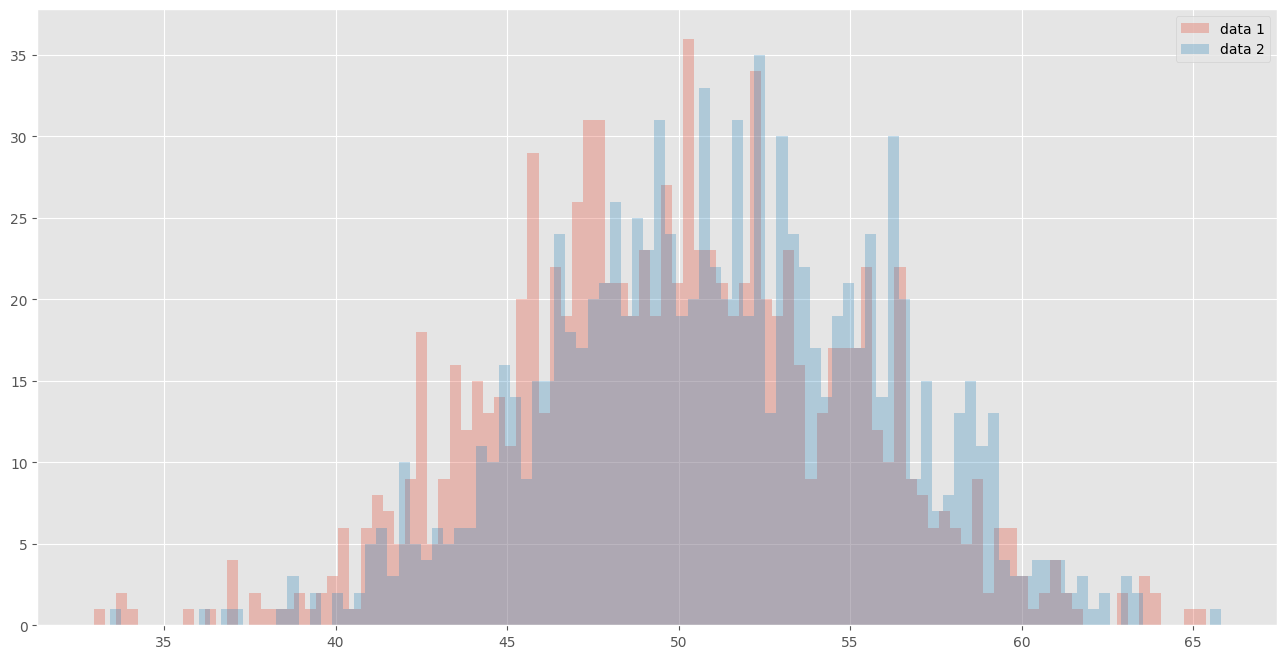

In [47]:
plt.figure(figsize=(16, 8))
plt.hist(data1, bins=100, alpha=0.3, label="data 1")
plt.hist(data2, bins=100, alpha=0.3, label="data 2")
plt.legend()
plt.show()

Перед тестом смотрим форму распределений: это помогает понять, подходит ли параметрический подход.


In [48]:
stat, p = mannwhitneyu(data1, data2)
print(f"Statistics={stat}, p={p}")
alpha = 0.05
if p > alpha:
    print("Same distribution (fail to reject H0)")
else:
    print("Different distribution (reject H0)")

Statistics=422194.0, p=1.6881503727442319e-09
Different distribution (reject H0)


Вывод по p‑value: p < 0.05 — различия значимы; p ≥ 0.05 — статистически не доказаны.


In [49]:
num_tests = 10000

In [51]:
counter_acc = 0
stats_same = []
for i in tqdm(range(num_tests)):
    data1 = 5 * np.random.randn(1000) + 50
    data2 = 5 * np.random.randn(1000) + 50
    stat, p = mannwhitneyu(data1, data2)
    counter_acc += p > alpha
    stats_same.append(stat)

# второе число - доля принятия альтернативной гипотезы, при условии что различий нет
# это вероятность ошибки первого рода
fpr = (num_tests - counter_acc) / num_tests
print(f"FPR: {fpr:.3f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

FPR: 0.051


Ошибка I рода: когда H0 верна, но мы ее отвергаем. Это и есть уровень значимости.


In [55]:
counter_acc = 0
stats_diff = []
for i in tqdm(range(num_tests)):
    data1 = 5 * np.random.randn(1000) + 50
    data2 = 5 * np.random.randn(1000) + 51
    stat, p = mannwhitneyu(data1, data2)
    counter_acc += p > alpha
    stats_diff.append(stat)

power = (num_tests - counter_acc) / num_tests
print(f"Power: {power:.3f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Power: 0.992


Ошибка II рода: H1 верна, но мы не отвергаем H0. Важна для мощности теста.


## Идея теста
Хотим статистику, которая заметно реагирует на изменение параметра, и минимально реагирует на шум.


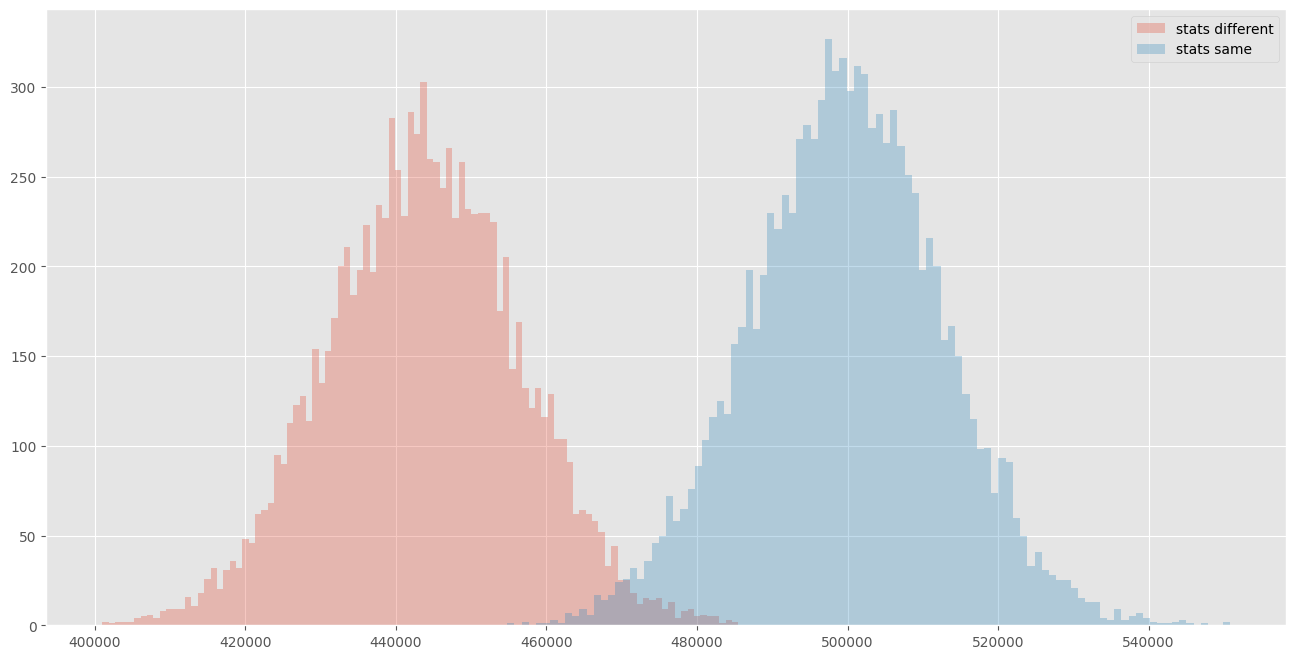

In [56]:
plt.figure(figsize=(16, 8))
plt.hist(stats_diff, bins=100, alpha=0.3, label="stats different")
plt.hist(stats_same, bins=100, alpha=0.3, label="stats same")
plt.legend()
plt.show()

# 2. Сплитовалка

Покажем, как неправильное разбиение может дать ложный эффект.


In [59]:
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("sample_data.csv")

## Неслучайное разбиение

Разобьем очень странным способом. Половину выборки в одну группу, другую в другую

Это намеренно «плохой» сплит — систематическое смещение между группами.


In [60]:
data["treatment"] = [0] * (len(data) // 2) + [1] * (len(data) // 2 + 1)

Возьмем тритмент группу (тестовую) и контрольную группу и проведем между ними т-тест


In [61]:
treated_group = data.loc[data["treatment"] == 1]["pnl_rub"]
control_group = data.loc[data["treatment"] == 0]["pnl_rub"]
stat, p = ttest_ind(treated_group, control_group)

stat, p

(np.float64(9.46761481578222), np.float64(3.1389278542200025e-21))

Из‑за смещения можно получить «значимость», даже если эффекта нет.


## Случайное разбиение

Хеш‑сплит с солью: стабильная случайность и воспроизводимое разбиение.


In [62]:
from tqdm import tqdm_notebook
import hashlib
import pandas
import scipy.stats
from sklearn.metrics import mutual_info_score
import statsmodels.api as sm


def ab_split(id, salt, control_group_size):
    """
    Returns 't' (for test) or 'c' (for control), based on the ID and salt.
    The control_group_size is a float, between 0 and 1, that sets how big the
    control group is.
    """

    test_id = str(id) + "-" + str(salt)
    test_id_digest = hashlib.md5(test_id.encode("ascii")).hexdigest()
    test_id_first_digits = test_id_digest[:6]
    test_id_final_int = int(test_id_first_digits, 16)
    ab_split = test_id_final_int / 0xFFFFFF

    if ab_split > control_group_size:
        return 0
    else:
        return 1

`salt` позволяет менять разбиение, не меняя исходные идентификаторы.


In [63]:
data["treatment_with_salt"] = data.uid.apply(lambda uid: ab_split(uid, "test-1", 0.5))

Проведем снова тест и увидим, что даже случайным разбиением группы по средним похожи (не отвергается 0 гипотеза о равенстве средних при уровне значимости 0.05)

In [64]:
treated_group = data.loc[data["treatment_with_salt"] == 1]["pnl_rub"]
control_group = data.loc[data["treatment_with_salt"] == 0]["pnl_rub"]
stat, p = ttest_ind(treated_group, control_group)

stat, p

(np.float64(1.496659096520079), np.float64(0.1344961617650426))

При корректном сплите различий обычно нет — H0 не отвергается.


## A/A тесты для валидации качества сплита

A/A: проверяем, что p‑values распределены равномерно, когда эффекта нет.


Идея метода A/A: мы искусственно делим одну и ту же популяцию на две группы, где эффекта **точно нет**. Если тест и пайплайн корректны, p‑values должны быть равномерны на [0,1], а доля ложных срабатываний близка к α. Если равномерность ломается — значит проблема в разбиении, метрике, тесте или реализации.


###  Тест, который сходится

Большие выборки и ЦПТ часто делают t‑test устойчивым даже для не‑нормальных данных.


In [65]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# np.random.seed(42)

  0%|          | 0/1000 [00:00<?, ?it/s]

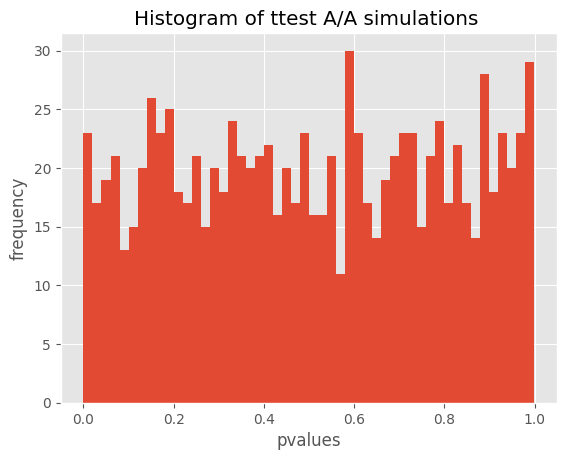

FPR: 4.90%


In [ ]:
n = 100_000
simulations = 1000
n_s = 1000
res = []

df = pd.DataFrame(
    {
        "s1": np.random.exponential(scale=1 / 0.001, size=n),
        "s2": np.random.exponential(scale=1 / 0.001, size=n),
    }
)

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df["s1"].sample(n_s, replace=False).values
    s2 = df["s2"].sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1])  # сохраняем pvalue

plt.hist(res, bins=50)
plt.style.use("ggplot")
plt.xlabel("pvalues")
plt.ylabel("frequency")
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
# FPR / Наблюдаемая O1Р
print(f"FPR: {sum(np.array(res) < 0.05) / simulations * 100:.2f}%")

Проверим равномерность p‑values через K‑S тест (сравнение с Uniform).


In [68]:
from scipy.stats import kstest, uniform


def is_uniform(sample, significance_level):
    # Perform the Kolmogorov-Smirnov test
    _, p_value = kstest(sample, uniform.cdf)

    return p_value


significance_level = 0.05
# Example usage
p_value = is_uniform(res, significance_level)

if p_value > significance_level:
    print("Uniform")  # Sample distribution is likely uniform
else:
    print("Not Uniform")  # Sample distribution is not likely uniform

p_value

Uniform


np.float64(0.6439895154209744)

## A/A-тест не сходится


Здесь уже есть эффект 10% — это скорее A/B, поэтому равномерности не будет.


  0%|          | 0/1000 [00:00<?, ?it/s]

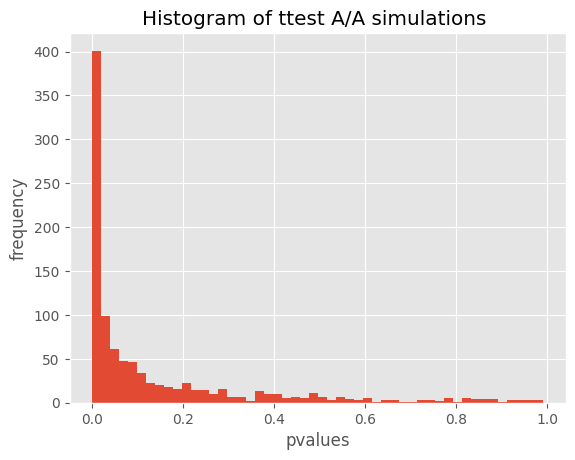

FPR: 53.40%


In [70]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df = pd.DataFrame(
    {
        "s1": np.random.exponential(scale=1 / 0.001, size=n),
        "s2": np.random.exponential(scale=1 / 0.001, size=n)
        * 1.1,  # добавляем эффект 10%
    }
)

for i in tqdm(range(simulations)):
    s1 = df["s1"].sample(n_s, replace=False).values
    s2 = df["s2"].sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1])

plt.hist(res, bins=50)
plt.style.use("ggplot")
plt.xlabel("pvalues")
plt.ylabel("frequency")
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# FPR не сойдется
print(f"FPR: {sum(np.array(res) < 0.05) / simulations * 100:.2f}%")

Из‑за эффекта p‑values сдвигаются к малым значениям.


In [71]:
significance_level = 0.05
# Example usage
p_value = is_uniform(res, significance_level)

if p_value > significance_level:
    print("Uniform")  # Sample distribution is likely uniform
else:
    print("Not Uniform")  # Sample distribution is not likely uniform

p_value

Not Uniform


np.float64(4.61053563e-316)

Сравнение с Uniform подтверждает, что распределение p‑values не равномерное.


# Итог

Что посмотрели на семинаре:
- Показываем базовый t‑test: формулируем H0/H1, смотрим p‑value, интерпретируем значимость.  
- Проверяем влияние ненормальности через симуляции и оцениваем ошибку I рода.  
- Сравниваем t‑test и Mann‑Whitney: когда непараметрический тест уместнее.  
- Обсуждаем ошибки I и II рода и как они проявляются в симуляциях.  
- Демонстрируем риск “плохого” разбиения групп и ложной значимости.  
- Показываем хеш‑сплит с солью как более корректное разбиение.  
- Вводим A/A‑тесты как проверку корректности пайплайна: p‑values должны быть равномерными при отсутствии эффекта.